In [ ]:
---
title: "Prueba de Quarto"
pdf-engine-opt: --no-toc-
format:
    html:
        toc: true
        code-fold: false
---

## API sobre datos de transporte

En este ejemplo vamos a conectarnos con una [API Transporte](https://www.buenosaires.gob.ar/desarrollourbano/transporte/apitransporte) del Gobierno de la Ciudad que nos da información del transporte, como por ejemplo estado del trańsito y estado actual del subte. 

Este tipo de APIs son quizás las más aprovechables a la hora de pensar en desarrollar una aplicación, dado que los datos no son estáticos sino que se van actualizando a cada momento. Piensen en servicios que reciben la ubicación de los colectivos y devuelve esa información volcada en un mapa, o bien que calcule el tiempo de recorrido dado el estado del tránsito en tiempo real. Estos datos combinados con las herramientas y modelos vistos en la materia le dan un valor más que interesante.

Para usar esta API tienen que registrarse [aquí](https://www.buenosaires.gob.ar/desarrollourbano/transporte/apitransporte), con lo cual obtienen las claves *client_id* y *client_secret* que en este caso (según la documentación) se pasan como parámetros en cada request.

#### Módulos 

In [1]:
# Cargamos en memoria los modulos necesarios
import pandas as pd
import matplotlib.pyplot as plt 
from pandas.io.json import json_normalize
import geopandas as gpd
import altair as alt

# Importamos la librería requests y json para formatear la salida
import requests
import json

# Solamente hace falta client_id y client_secret
# Se sacan registrandose en 
# https://www.buenosaires.gob.ar/desarrollourbano/transporte/apitransporte

client_id = "18b8b37c9d5f4e39a5dd0f41ba5c925f"
client_secret = "77F1e9f202eC4cEDb106191f62Ac7e92"

# Estas claves van a ser borradas proximamente, generar sus propias claves

Matplotlib is building the font cache; this may take a moment.


#### Función para cargar información conectándose a la API 

In [5]:
def load_data(topic):
    # Token
    client_id = "18b8b37c9d5f4e39a5dd0f41ba5c925f"
    client_secret = "77F1e9f202eC4cEDb106191f62Ac7e92"
    
    # json y agency_id solo son requeridos para buses, pero si lo pasamos en el resto de los topic,
    # funciona sin problema.
    params = {'client_id': client_id, 'client_secret': client_secret, 'json': 1, 'agency_id': 2}
    
    # URL
    url = "https://apitransporte.buenosaires.gob.ar"
    
    # dict con cada end_point y columna para procesar según topic
    dict_topic ={
      'stations_st': {'end_point':'/ecobici/gbfs/stationStatus',
                      'columns':'data',
                     'params':''},
      'stations_inf': {'end_point':'/ecobici/gbfs/stationInformation',
                      'columns':'data',
                      'params':''},
      'incidents': {'end_point':'/transito/v1/cortes',
                      'columns':'incidents',
                      'params':''},
      'buses': {'end_point':'/colectivos/vehiclePositions',
                'columns':'_vehicle'
               }
    } 
    
    if (topic in list(dict_topic.keys())):
        
        url_to_get = url + dict_topic[topic]['end_point']
        response = requests.get(url_to_get, params = params)
        json_data = response.json()
        
        if topic == 'buses':
            df = pd.DataFrame(json_data['_entity'])
        
        else:
            df = pd.read_json(json.dumps(json_data))

        df = pd.concat([pd.DataFrame(pd.json_normalize(x)) for x in df[dict_topic[topic]['columns']]],ignore_index=True)
    
    else:
    
        print('ERROR: No existe ese topic')
        return
     
    return df

## Ejemplos de uso

La forma general de comunicarse con esta API es la siguiente: 
~~~
"https://apitransporte.buenosaires.gob.ar" + end_point 
~~~
donde *end_point* los pueden tomar de la [documentación](https://www.buenosaires.gob.ar/desarrollourbano/transporte/apitransporte/api-doc).

Todos los parámetros que necesiten (además de que siempre vamos a tener que pasarle las claves) van al diccionario de parámetros.

### Posición de colectivos monitoreados

In [6]:
bus = load_data('buses')

###### Ejemplo de utilización de estos datos:

In [7]:
# Datos de los límites de diferentes municipios del país levantados con geopandas
# Cuando marquemos los buses, sólo se verá capital, que es por donde circulan.
# De todas formas, se podría filtrar como con cualquier dataframe.
data_muni = gpd.read_file('shape/comunas/comunas_wgs84.shp')

In [8]:
data_muni

,ID,OBJETO,COMUNAS,BARRIOS,PERIMETRO,AREA,geometry
0,1,LIMITE COMUNAL,2.0,RECOLETA,21452.838648,6.317265e+06,"POLYGON ((-58.38000 -34.57002, -58.38002 -34.5..."
1,3,LIMITE COMUNAL,6.0,CABALLITO,10990.964471,6.851029e+06,"POLYGON ((-58.43061 -34.60705, -58.43056 -34.6..."
2,6,LIMITE COMUNAL,10.0,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,"POLYGON ((-58.48834 -34.62016, -58.48820 -34.6..."
3,7,LIMITE COMUNAL,11.0,VILLA DEL PARQUE - VILLA DEVOTO - VILLA GRAL....,19987.696155,1.412004e+07,"POLYGON ((-58.49838 -34.59637, -58.49718 -34.5..."
4,8,LIMITE COMUNAL,12.0,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,17232.189372,1.557093e+07,"POLYGON ((-58.50331 -34.59386, -58.50347 -34.5..."
5,9,LIMITE COMUNAL,14.0,PALERMO,22126.531858,1.584587e+07,"POLYGON ((-58.42676 -34.55202, -58.42676 -34.5..."
6,11,LIMITE COMUNAL,15.0,AGRONOMIA - CHACARITA - PARQUE CHAS - PATERN...,17832.585580,1.432290e+07,"POLYGON ((-58.42602 -34.59661, -58.42484 -34.5..."
7,15,LIMITE COMUNAL,13.0,BELGRANO - COLEGIALES - NUÑEZ,26198.826953,1.471321e+07,"POLYGON ((-58.44033 -34.54022, -58.44032 -34.5..."
8,13,LIMITE COMUNAL,4.0,BARRACAS - BOCA - NUEVA POMPEYA - PARQUE PATRI...,35423.282799,2.168464e+07,"POLYGON ((-58.38864 -34.63373, -58.38864 -34.6..."
9,2,LIMITE COMUNAL,5.0,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"POLYGON ((-58.43333 -34.60267, -58.43314 -34.6..."


In [9]:
bus

,_congestion_level,_current_status,_current_stop_sequence,_occupancy_status,_stop_id,_timestamp,extensionObject,_position._bearing,_position._latitude,_position._longitude,...,_trip._schedule_relationship,_trip._start_date,_trip._start_time,_trip._trip_id,_trip.extensionObject,_vehicle._id,_vehicle._label,_vehicle._license_plate,_vehicle.extensionObject,_trip
0,0,2,19,0,20488,1686948238,None,0,-34.60909,-58.386300,...,0.0,20230616,17:15:00,103420-1,None,33871,16-156,None,None,NaN
1,0,2,23,0,203403,1686948238,None,0,-34.59203,-58.389460,...,0.0,20230616,16:51:30,103833-1,None,33878,30-156,None,None,NaN
2,0,2,0,0,None,1686948236,None,0,-34.64168,-58.369560,...,NaN,NaN,NaN,NaN,NaN,33886,22-156,None,None,None
3,0,1,1,0,2031571,1686948236,None,0,-34.64172,-58.369255,...,0.0,20230616,17:41:30,103853-1,None,33892,28-156,None,None,NaN
4,0,2,9,0,203444,1686948234,None,0,-34.58704,-58.397540,...,0.0,20230616,17:35:00,103428-1,None,33897,32-156,None,None,NaN
5,0,2,29,0,20370,1686948238,None,0,-34.62951,-58.378914,...,0.0,20230616,17:00:00,103414-1,None,33898,3-156,None,None,NaN
6,0,2,7,0,203612,1686948236,None,0,-34.58369,-58.401535,...,0.0,20230616,17:35:00,103428-1,None,33904,4-156,None,None,NaN
7,0,2,24,0,2031568,1686948238,None,0,-34.59059,-58.392666,...,0.0,20230616,16:51:30,103833-1,None,34236,33-156,None,None,NaN
8,0,2,6,0,203207,1686948238,None,0,-34.58221,-58.401600,...,0.0,20230616,17:37:30,103429-1,None,35163,8-156,None,None,NaN
9,0,2,8,0,203605,1686948208,None,0,-34.58491,-58.400040,...,0.0,20230616,17:32:30,103427-1,None,35166,15-156,None,None,NaN


In [10]:
bus.rename(columns = {'_position._longitude': 'lon', 
                      '_position._latitude': 'lat', 
                     }, 
                inplace = True)

#### Altair 

In [11]:
points = alt.Chart(bus).mark_circle().encode(
    longitude='lon:Q',
    latitude='lat:Q',
    tooltip=['_congestion_level'],
)

caba = alt.Chart(data_muni).mark_geoshape(
    stroke='white',
    fill='lightgray').encode().properties(width=800,height=800).project('mercator')

caba+points

alt.LayerChart(...)

#### Pandas 

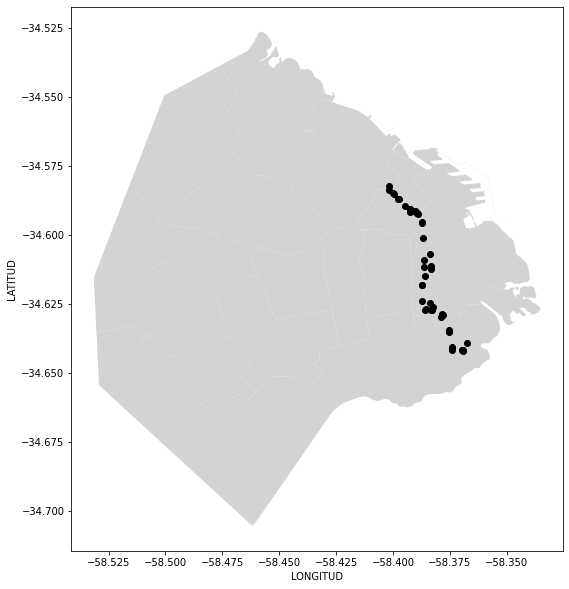

In [12]:
# Creamos la figura con matplotlib
fig, ax = plt.subplots(figsize = (10, 10))

# Ploteamos el shape cargado anteriormente. Es todo el país, pero sólo se verá CABA
data_muni.plot(ax=ax, color='lightgrey')
# La posición de los colectivos
x = bus['lon']
y = bus['lat']
ax.scatter(x, y, color = 'k')

# Labels de los ejes
ax.set_xlabel('LONGITUD') 
ax.set_ylabel('LATITUD');

### Estado de estaciones de EcoBici

In [13]:
# Cargamos la info de las estaciones: status e information

stations_inf = load_data('stations_inf')
stations_st = load_data('stations_st')

In [15]:
stations_st

,station_id,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,num_bikes_available_types.mechanical,num_bikes_available_types.ebike
0,2,25,4,7,0,1.686948e+09,False,IN_SERVICE,1,1,1,None,25,0
1,3,1,0,27,0,1.686948e+09,False,IN_SERVICE,1,1,1,None,1,0
2,4,4,0,16,0,1.686948e+09,False,IN_SERVICE,1,1,1,None,4,0
3,5,14,2,26,0,1.686949e+09,False,IN_SERVICE,1,1,1,None,14,0
4,6,11,1,8,0,1.686948e+09,False,IN_SERVICE,1,1,1,None,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,494,0,1,11,0,1.686948e+09,False,IN_SERVICE,1,1,1,None,0,0
327,496,5,0,7,0,1.686948e+09,False,IN_SERVICE,1,1,1,None,5,0
328,497,5,0,7,0,1.686948e+09,False,IN_SERVICE,1,1,1,None,5,0
329,498,2,0,10,0,1.686948e+09,False,IN_SERVICE,1,1,1,None,2,0


#### Merge 

In [16]:
stations = pd.merge(stations_inf,
                    stations_st,
                    how='left')

In [17]:
stations

,station_id,name,physical_configuration,lat,lon,altitude,address,post_code,capacity,is_charging_station,...,num_docks_available,num_docks_disabled,last_reported,status,is_installed,is_renting,is_returning,traffic,num_bikes_available_types.mechanical,num_bikes_available_types.ebike
0,2,002 - Retiro I,SMARTLITMAPFRAME,-34.592424,-58.374710,0.0,AV. Dr. José María Ramos Mejía 1300,11111,36,False,...,7,0,1.686948e+09,IN_SERVICE,1,1,1,None,25,0
1,3,003 - ADUANA,SMARTLITMAPFRAME,-34.611102,-58.368174,0.0,Moreno & Azopardo,11111,28,False,...,27,0,1.686948e+09,IN_SERVICE,1,1,1,None,1,0
2,4,004 - Plaza Roma,SMARTLITMAPFRAME,-34.603008,-58.368856,0.0,Av. Corrientes 100,11111,20,False,...,16,0,1.686948e+09,IN_SERVICE,1,1,1,None,4,0
3,5,005 - Plaza Italia,SMARTLITMAPFRAME,-34.580550,-58.420954,0.0,Av. Sarmiento 2601,1111,42,False,...,26,0,1.686949e+09,IN_SERVICE,1,1,1,None,14,0
4,6,006 - Parque Lezama,SMARTLITMAPFRAME,-34.628526,-58.369758,0.0,"Avenida Martin Garcia, 295",1111,20,False,...,8,0,1.686948e+09,IN_SERVICE,1,1,1,None,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,494,314 - ALLENDE,SMARTLITMAPFRAME,-34.614787,-58.511672,0.0,Allende 2794,C1417,12,False,...,11,0,1.686948e+09,IN_SERVICE,1,1,1,None,0,0
312,496,052 - CAMPANA II,REGULARLITMAPFRAME,-34.583160,-58.513166,0.0,Cochrane 3298 (y Campana),1111,12,False,...,7,0,1.686948e+09,IN_SERVICE,1,1,1,None,5,0
313,497,307 - CERRETTI,SMARTLITMAPFRAME,-34.574424,-58.496232,0.0,Ceretti 2892,C1431,12,False,...,7,0,1.686948e+09,IN_SERVICE,1,1,1,None,5,0
314,498,055 - HABANA,SMARTLITMAPFRAME,-34.586598,-58.494959,0.0,Gral. José Gervasio Artigas 4298 (y Habana),C1419,12,False,...,10,0,1.686948e+09,IN_SERVICE,1,1,1,None,2,0


#### Alternativa 1: Geopandas 

In [18]:
gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations['lon'], stations.lat))
gdf.crs = {"init": "EPSG:4326"}
gdf = gdf.to_crs(epsg = 5343)

/home/mato/miniconda3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [19]:
data_muni.crs = {"init": "EPSG:4326"}
data_muni = data_muni.to_crs(epsg = 5343)

/home/mato/miniconda3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


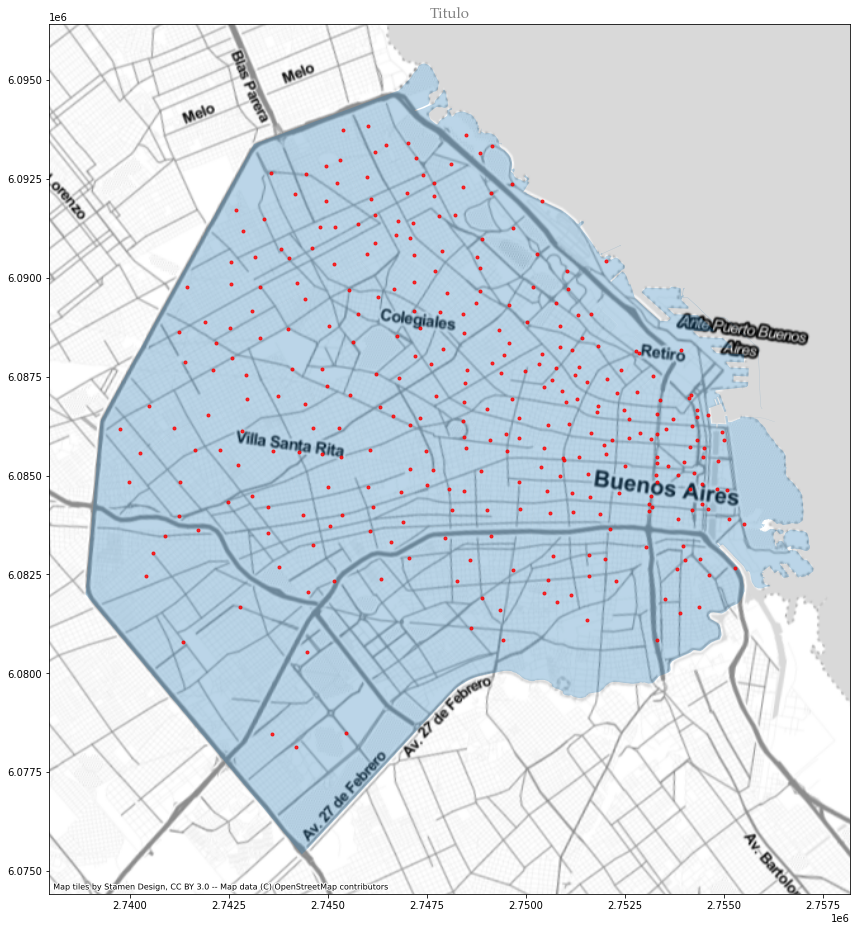

In [21]:
import contextily as ctx

fig, ax = plt.subplots(figsize=(16,16))

data_muni.plot(ax=ax, alpha = 0.3)

gdf.plot(ax=ax, color = 'red', marker = '.', alpha=0.8)

ctx.add_basemap(ax, crs='epsg:5343',source=ctx.providers.Stamen.TonerLite)

plt.title('Titulo', fontsize=15, fontname='Palatino Linotype', color='grey')
plt.show()

#### Alternativa 2: Altair

In [ ]:
stations_st.head()

In [24]:
import altair as alt

In [25]:
# Error comun en altair:
# Altair uses Data Transformers and requires all the columns to be “JSON Serializable”.
# This means that you should not have a geometric data type among your columns.
# Por eso, borramos la columna geometry
stations = stations[['station_id', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'post_code', 'capacity', 'is_charging_station',
       'rental_methods', 'groups', 'obcn', 'nearby_distance', 'cross_street',
       'num_bikes_available', 'num_bikes_disabled', 'num_docks_available',
       'num_docks_disabled', 'last_reported', 'status', 'is_installed',
       'is_renting', 'is_returning', 'traffic',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike']]

In [26]:
# !pip3 install contextily


In [27]:
points = alt.Chart(stations).mark_circle().encode(
    longitude='lon:Q',
    latitude='lat:Q',
    size=alt.value(80),
    color='num_bikes_available',
    tooltip=['name','address','num_bikes_available', 'num_bikes_disabled', 'num_docks_available','last_reported'],
).properties(
    width=500,
    height=400
)

data_muni = gpd.read_file('shape/comunas/comunas_wgs84.shp')

caba = alt.Chart(data_muni).mark_geoshape(stroke='white',
                            fill='lightgray').encode().properties(width=800,
                                                                 height=800).project('mercator')
mapa = caba + points

mapa

alt.LayerChart(...)

### Cortes de tránsito

In [28]:
incidents = load_data('incidents')

ValueError: If using all scalar values, you must pass an index

In [ ]:
incidents

### Carga de datos sin función

#### Buses

In [29]:
# Claves como parametros, mas los parametros propios de cada endpoint
# Aquí tenemos que pedirle explícitamente que nos devuelva los datos en json
params = {'client_id': client_id, 'client_secret': client_secret, 'json': 1, 'agency_id': 2}

# Url y end point (lo vemos siempre en la documentación)
url = "https://apitransporte.buenosaires.gob.ar"
end_point = "/colectivos/vehiclePositions"
print(url+end_point)
# Método get
response = requests.get(url + end_point, params = params)

https://apitransporte.buenosaires.gob.ar/colectivos/vehiclePositions


In [30]:
print(params)

{'client_id': '18b8b37c9d5f4e39a5dd0f41ba5c925f', 'client_secret': '77F1e9f202eC4cEDb106191f62Ac7e92', 'json': 1, 'agency_id': 2}


In [38]:
# Respuesta en formato json
json_data = response.json()

# print (json_data)
# Llamamos a dumps para que la salida sea más fácil de leer 
# print(json.dumps(json_data, indent = 4))

# bus=pd.read_json(json.dumps(json_data['_vehicle']))
bus = pd.DataFrame(json_data['_entity'])

# Abrimos el campo _vehicle, que es otro json, pero tiene la info que nos interesa.
bus = pd.concat([pd.DataFrame(pd.json_normalize(x)) for x in bus['_vehicle']],ignore_index=True)

In [39]:
bus

,_congestion_level,_current_status,_current_stop_sequence,_occupancy_status,_stop_id,_timestamp,extensionObject,_position._bearing,_position._latitude,_position._longitude,...,_trip._schedule_relationship,_trip._start_date,_trip._start_time,_trip._trip_id,_trip.extensionObject,_vehicle._id,_vehicle._label,_vehicle._license_plate,_vehicle.extensionObject,_trip
0,0,2,30,0,20376,1686949556,None,0,-34.63631,-58.375065,...,0.0,20230616,17:15:00,103420-1,None,33871,16-156,None,None,NaN
1,0,2,0,0,None,1686949556,None,0,-34.57238,-58.411606,...,NaN,NaN,NaN,NaN,NaN,33878,30-156,None,None,None
2,0,2,0,0,None,1686949556,None,0,-34.64209,-58.369920,...,NaN,NaN,NaN,NaN,NaN,33886,22-156,None,None,None
3,0,2,10,0,205478,1686949556,None,0,-34.62475,-58.385315,...,0.0,20230616,17:41:30,103853-1,None,33892,28-156,None,None,NaN
4,0,2,18,0,20414,1686949556,None,0,-34.60864,-58.386240,...,0.0,20230616,17:35:00,103428-1,None,33897,32-156,None,None,NaN
5,0,2,0,0,None,1686949556,None,0,-34.64167,-58.369545,...,NaN,NaN,NaN,NaN,NaN,33898,3-156,None,None,None
6,0,2,20,0,20486,1686949558,None,0,-34.61185,-58.386100,...,0.0,20230616,17:35:00,103428-1,None,33904,4-156,None,None,NaN
7,0,2,12,0,20503,1686949556,None,0,-34.62271,-58.387180,...,0.0,20230616,17:54:00,103858-1,None,33910,6-156,None,None,NaN
8,0,2,6,0,203207,1686949526,None,0,-34.58282,-58.401930,...,0.0,20230616,18:00:00,103438-1,None,34236,33-156,None,None,NaN
9,0,2,19,0,20488,1686949556,None,0,-34.60916,-58.386440,...,0.0,20230616,17:37:30,103429-1,None,35163,8-156,None,None,NaN


#### Incidentes (idem a stationsstatus y stationsinformation) 

In [40]:
# # Claves como parametros, mas los parametros propios de cada endpoint
params = {'client_id': client_id, 'client_secret': client_secret}

# # Url y end point (lo vemos siempre en la documentación)
url = "https://apitransporte.buenosaires.gob.ar"
end_point = "/transito/v1/cortes"

# # Método get
response = requests.get(url + end_point, params = params)

# # Respuesta en formato json
json_data = response.json()

# # Llamamos a dumps para que la salida sea más fácil de leer 
print(json.dumps(json_data, indent = 4))

{
    "error": "/transito/v1/cortes (org.mule.module.apikit.exception.NotFoundException).",
    "message": null
}
